# Model analysis

In [1]:
import warnings
import numpy as np
import tensorflow as tf
import pandas as pd
from sklearn.metrics import classification_report


warnings.filterwarnings("ignore")

In [2]:
import sys
sys.path.append("../")

from scripts.model import create_model

In [3]:
dummy_model = create_model(1e-3)
dummy_model.build((None, 28, 28))
model_from_ckpt = tf.keras.saving.load_model("../checkpoint/")

In [4]:
print("Model from checkpoint")
model_from_ckpt.summary()

print("\nModel from training file")
dummy_model.summary()

Model from checkpoint
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 16)                12560     
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense_3 (Dense)             (None, 10)                170       
                                                                 
Total params: 12730 (49.73 KB)
Trainable params: 12730 (49.73 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________

Model from training file
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                

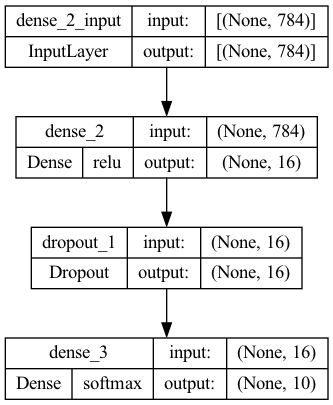

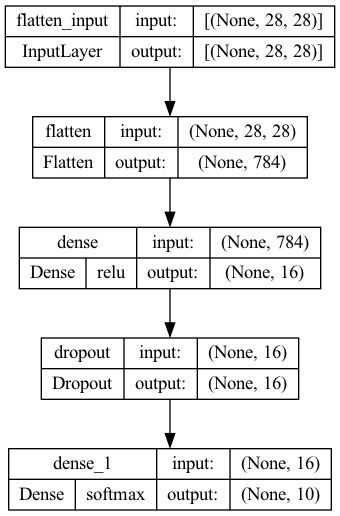

In [9]:
display(tf.keras.utils.plot_model(model_from_ckpt, show_shapes=True, show_layer_activations=True))
display(tf.keras.utils.plot_model(dummy_model, show_shapes=True, show_layer_activations=True))

In [16]:
dummy_input = np.zeros((1, 28, 28))
print(dummy_model.predict(dummy_input))
print(model_from_ckpt.predict(dummy_input.reshape(1, 784)))

1/1 [==============================] - 0s 22ms/step
[[0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]]
1/1 [==============================] - 0s 12ms/step
[[0.1052354  0.12885886 0.05414566 0.08328817 0.07449424 0.18258691
  0.10668295 0.16862217 0.03097621 0.06510942]]


# Testing

In [33]:
test = pd.read_csv("../data/mnist_test.csv")
x = test.iloc[:, 1:].values / 255.0
y = test.label.values

In [26]:
preds = model_from_ckpt.predict(x)
preds = preds.argmax(1)

313/313 [==============================] - 0s 449us/step


In [34]:
report = classification_report(y, preds)
print(report)

              precision    recall  f1-score   support

           0       0.95      0.97      0.96       980
           1       0.96      0.98      0.97      1135
           2       0.94      0.92      0.93      1032
           3       0.94      0.92      0.93      1010
           4       0.94      0.93      0.94       982
           5       0.93      0.91      0.92       892
           6       0.94      0.96      0.95       958
           7       0.94      0.93      0.94      1028
           8       0.92      0.91      0.91       974
           9       0.91      0.93      0.92      1009

    accuracy                           0.94     10000
   macro avg       0.94      0.94      0.94     10000
weighted avg       0.94      0.94      0.94     10000



# Выводы

1. Архитектура модели в файле обучения не соответствует той, которая предоставленна в виде чекпоинта в папке 'v1/'
2. Нет фиксации seed во время обучения
3. Нет сохранения результатов валидации, что затрудняет оценку модели, при передаче ее другим разработчикам


Модель чекпоинта состоит из 3 слоев: 2 линейных слоя между которыми стоит dropout слой. Также после 1 линейного слоя применяется активация ReLU, для того, чтобы внести нелинейность в модель. После второго линейного слоя применяется активация Softmax приводящая выходы модели к виду где i-й элемент результирующего массива является вероятностью того, что i-й класс является ответом. 
На вход модель принимает изображение приведенное к формату (batch_size, 28x28). На выход выдает массив размера (batch_size, num_classes), так как для обучения используется датасет MNIST, то num_classes = 10 -- кол-во цифр. 

Dense реализует операцию: output = activation(dot(input, kernel) + bias), где активация — это функция активации по элементам, переданная в качестве аргумента активации, кернел — это матрица весов, созданная слоем, а смещение — это вектор смещения, созданный слоем (применимо только в случае, если use_bias — True).

Слой Dropout состоит в случайной установке доли единиц ввода в 0 при каждом обновлении во время обучения, что помогает предотвратить переобучение (оверфиттинг). В даннос случае значение rate=0.1



